# Предсказание стоимости жилья

В проекте обучается модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. Обучим модель и сделаем предсказания на тестовой выборке. Для оценки качества модели используем метрики RMSE, MAE и R2. Помимо этого соберем всю цепочку обработки фичей в пайплайн, прогоним все это через grid search и посмотрим значение метрик на кросс-валдиации.

В колонках датасета содержатся следующие данные:

- `longitude` — широта;
- `latitude` — долгота;
- `housing_median_age` — медианный возраст жителей жилого массива;
- `total_rooms` — общее количество комнат в домах жилого массива;
- `total_bedrooms` — общее количество спален в домах жилого массива;
- `population` — количество человек, которые проживают в жилом массиве;
- `households` — количество домовладений в жилом массиве;
- `median_income` — медианный доход жителей жилого массива;
- `median_house_value`— медианная стоимость дома в жилом массиве;
- `ocean_proximity` — близость к океану.

## Импорт библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import*
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import GBTRegressor
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

## Инициализируем Spark сессию и загружаем данные

In [2]:
spark = SparkSession.builder.master("local").appName("Housing").getOrCreate()

Загрузка данных

In [3]:
df = spark.read.option('header', 'true').csv('/datasets/housing.csv', inferSchema = True)

## Первичный анализ и предобработка данных

In [4]:
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [5]:
df.describe().toPandas()

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,20640,20640,20640,20640,20433,20640,20640,20640,20640,20640
1,mean,-119.56970445736148,35.6318614341087,28.639486434108527,2635.7630813953488,537.8705525375618,1425.4767441860465,499.5396802325581,3.8706710029070246,206855.81690891474,None
2,stddev,2.003531723502584,2.135952397457101,12.58555761211163,2181.6152515827944,421.38507007403115,1132.46212176534,382.3297528316098,1.899821717945263,115395.61587441359,None
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,<1H OCEAN
4,max,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0,NEAR OCEAN


In [6]:
df.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity']

Смотрим пропуски

In [7]:
def find_misses(data):
    '''
    Функция для нахождения пропусков
    '''
    for column in data.columns:
        print(column, data.filter(F.column(column).isNull()).count())

In [8]:
find_misses(df)

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


In [9]:
df.filter(F.col('total_bedrooms').isNull()).toPandas()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,NEAR BAY
1,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0,NEAR BAY
2,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0,NEAR BAY
3,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,NEAR BAY
4,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
202,-119.19,34.20,18.0,3620.0,NaN,3171.0,779.0,3.3409,220500.0,NEAR OCEAN
203,-119.18,34.19,19.0,2393.0,NaN,1938.0,762.0,1.6953,167400.0,NEAR OCEAN
204,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,410700.0,<1H OCEAN
205,-118.75,34.29,17.0,5512.0,NaN,2734.0,814.0,6.6073,258100.0,<1H OCEAN


Заполним пропуски в столбце `total_bedrooms` медианой.

In [10]:
median = np.median(df.filter(F.col('total_bedrooms').isNotNull()).select('total_bedrooms').collect())
median

435.0

In [11]:
df = df.fillna(median, subset=['total_bedrooms'])

In [12]:
find_misses(df)

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 0
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


Смотрим на мультиколлинеарность

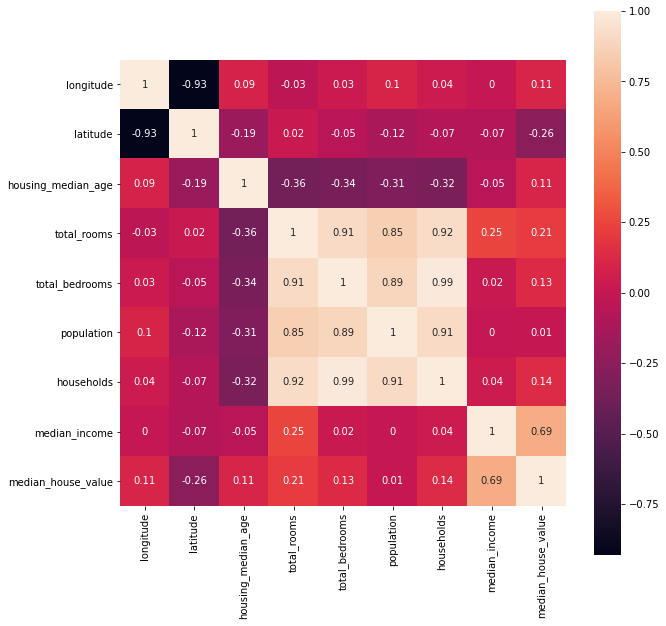

In [13]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.limit(10000).toPandas().corr().round(2), annot=True, square=True);

Удаляем выскокореллирующие признаки

In [14]:
df = df.drop('total_rooms', 'total_bedrooms', 'population', 'longitude')

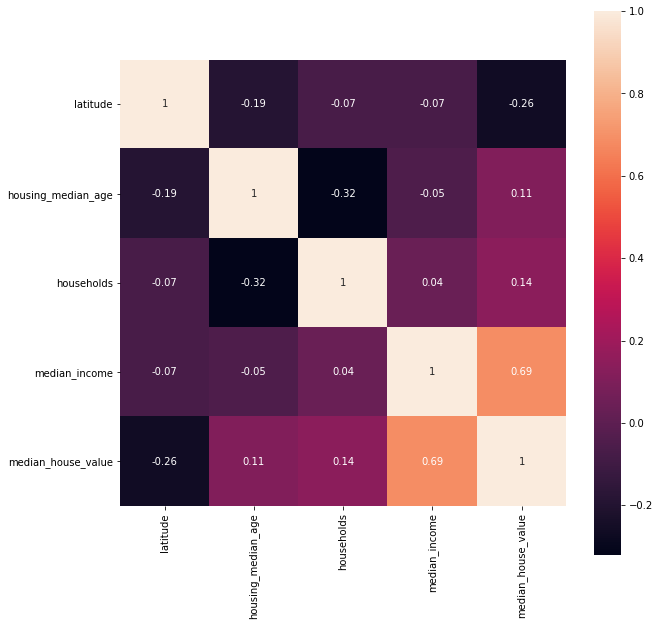

In [15]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.limit(10000).toPandas().corr().round(2), annot=True, square=True);

### Подготовка признаков

Разбиваем на численные и категориальные признаки

In [16]:
num_feutures = [column.name for column in df.schema if column.dataType == DoubleType()]
num_feutures.remove('median_house_value')
cat_feutures  = [column.name for column in df.schema if column.dataType == StringType()]
target = 'median_house_value'
num_feutures, cat_feutures, target

(['latitude', 'housing_median_age', 'households', 'median_income'],
 ['ocean_proximity'],
 'median_house_value')

### Разбиваем данные

In [17]:
def split_train_test():
    train_data, test_data = df.randomSplit([0.8, 0.2], seed=0)
    return train_data, test_data

In [18]:
train_data, test_data = split_train_test()

In [19]:
train_data.show(5)

+--------+------------------+----------+-------------+------------------+---------------+
|latitude|housing_median_age|households|median_income|median_house_value|ocean_proximity|
+--------+------------------+----------+-------------+------------------+---------------+
|   32.54|               7.0|     282.0|       1.2667|           67500.0|     NEAR OCEAN|
|   32.55|               5.0|     854.0|       1.4384|          108800.0|     NEAR OCEAN|
|   32.55|               8.0|    1177.0|       3.9583|          144400.0|     NEAR OCEAN|
|   32.55|              15.0|     648.0|       1.6348|           93200.0|     NEAR OCEAN|
|   32.56|               5.0|     855.0|       1.7301|          125000.0|     NEAR OCEAN|
+--------+------------------+----------+-------------+------------------+---------------+
only showing top 5 rows



In [20]:
train_data.show(5)

+--------+------------------+----------+-------------+------------------+---------------+
|latitude|housing_median_age|households|median_income|median_house_value|ocean_proximity|
+--------+------------------+----------+-------------+------------------+---------------+
|   32.54|               7.0|     282.0|       1.2667|           67500.0|     NEAR OCEAN|
|   32.55|               5.0|     854.0|       1.4384|          108800.0|     NEAR OCEAN|
|   32.55|               8.0|    1177.0|       3.9583|          144400.0|     NEAR OCEAN|
|   32.55|              15.0|     648.0|       1.6348|           93200.0|     NEAR OCEAN|
|   32.56|               5.0|     855.0|       1.7301|          125000.0|     NEAR OCEAN|
+--------+------------------+----------+-------------+------------------+---------------+
only showing top 5 rows



### Трансформация категориальных признаков

In [21]:
indexer = StringIndexer(inputCols=cat_feutures, outputCols=[c+'_idx' for c in cat_feutures],  handleInvalid='keep')
indexer = indexer.fit(train_data)
train_data = indexer.transform(train_data)
test_data = indexer.transform(test_data)

In [22]:
encoder = OneHotEncoder(inputCols=[c+'_idx' for c in cat_feutures], outputCols=[c+'_ohe' for c in cat_feutures])
encoder = encoder.fit(train_data)
test_data = encoder.transform(test_data)
train_data = encoder.transform(train_data)

Объединение признаков в один вектор

In [23]:
categorical_assembler = VectorAssembler(inputCols=[c+'_ohe' for c in cat_feutures], outputCol="categorical_features")
test_data = categorical_assembler.transform(test_data) 
train_data = categorical_assembler.transform(train_data) 

### Трансформация числовых признаков

In [24]:
numerical_assembler = VectorAssembler(inputCols=num_feutures, outputCol="numerical_features")
test_data = numerical_assembler.transform(test_data)
train_data = numerical_assembler.transform(train_data)

In [25]:
standardScaler = StandardScaler(inputCol='numerical_features', outputCol="numerical_features_scaled")
standardScaler = standardScaler.fit(train_data)
test_data = standardScaler.transform(test_data) 
train_data = standardScaler.transform(train_data) 

Объединение признаков в один вектор

In [26]:
all_features = ['categorical_features','numerical_features_scaled']
final_assembler = VectorAssembler(inputCols=all_features, outputCol="features") 
test_data = final_assembler.transform(test_data)
train_data = final_assembler.transform(train_data)

In [27]:
train_data.show(5)

+--------+------------------+----------+-------------+------------------+---------------+-------------------+-------------------+--------------------+--------------------+-------------------------+--------------------+
|latitude|housing_median_age|households|median_income|median_house_value|ocean_proximity|ocean_proximity_idx|ocean_proximity_ohe|categorical_features|  numerical_features|numerical_features_scaled|            features|
+--------+------------------+----------+-------------+------------------+---------------+-------------------+-------------------+--------------------+--------------------+-------------------------+--------------------+
|   32.54|               7.0|     282.0|       1.2667|           67500.0|     NEAR OCEAN|                2.0|      (5,[2],[1.0])|       (5,[2],[1.0])|[32.54,7.0,282.0,...|     [15.2512184954674...|[0.0,0.0,1.0,0.0,...|
|   32.55|               5.0|     854.0|       1.4384|          108800.0|     NEAR OCEAN|                2.0|      (5,[2],[1

In [28]:
test_data.show(5)

+--------+------------------+----------+-------------+------------------+---------------+-------------------+-------------------+--------------------+--------------------+-------------------------+--------------------+
|latitude|housing_median_age|households|median_income|median_house_value|ocean_proximity|ocean_proximity_idx|ocean_proximity_ohe|categorical_features|  numerical_features|numerical_features_scaled|            features|
+--------+------------------+----------+-------------+------------------+---------------+-------------------+-------------------+--------------------+--------------------+-------------------------+--------------------+
|   32.57|              17.0|      87.0|       5.1478|          138900.0|     NEAR OCEAN|                2.0|      (5,[2],[1.0])|       (5,[2],[1.0])|[32.57,17.0,87.0,...|     [15.2652792377804...|[0.0,0.0,1.0,0.0,...|
|   32.57|              17.0|     365.0|       4.6364|          141100.0|     NEAR OCEAN|                2.0|      (5,[2],[1

## Обучение модели

In [31]:
def find_metrics(model):
    '''
    Функция вывода метрик RMSE, MAE, R2
    '''
    predictions = model.transform(test_data)
    predicted = spark.sparkContext.parallelize(predictions.select(target, 'prediction').collect())
    metrics = RegressionMetrics(predicted)
    print(f'RMSE: {metrics.rootMeanSquaredError:.5}')
    print(f'MAE: {metrics.meanAbsoluteError:.5}')
    print(f'R2: {metrics.r2:.5}')

Модель линейной регрессии, используя все фичи

In [32]:
gbt = GBTRegressor(labelCol=target, featuresCol='features')
model = gbt.fit(train_data)
find_metrics(model)

23/08/26 04:07:58 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/08/26 04:07:58 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


RMSE: 6.6222e+04
MAE: 4.6262e+04
R2: 0.52173


## Собираем все в пайплайн

In [33]:
train_data, test_data = split_train_test()

In [34]:
# indexer = StringIndexer(inputCols=cat_feutures, outputCols=[c+'_idx' for c in cat_feutures],  handleInvalid='keep')
# encoder = OneHotEncoder(inputCols=[c+'_idx' for c in cat_feutures], outputCols=[c+'_ohe' for c in cat_feutures])
# categorical_assembler = VectorAssembler(inputCols=[c+'_ohe' for c in cat_feutures], outputCol="categorical_features")

# numerical_assembler = VectorAssembler(inputCols=num_feutures, outputCol="numerical_features")
# standardScaler = StandardScaler(inputCol='numerical_features', outputCol="numerical_features_scaled")
# all_features = ['categorical_features','numerical_features_scaled']
# final_assembler = VectorAssembler(inputCols=all_features, outputCol="features") 

pipeline = Pipeline(stages = [indexer,
                              encoder,
                              categorical_assembler,
                              numerical_assembler,
                              standardScaler,
                              final_assembler,
                              gbt
                              ]
                   )

In [35]:
pipeline_model = pipeline.fit(train_data)

In [36]:
find_metrics(pipeline_model)

RMSE: 6.6222e+04
MAE: 4.6262e+04
R2: 0.52173


## Оптимизация гиперпараметров

Посмотрим на возможности Spark  в плане оптимизации и кросс-валидации 

In [37]:
train_data, test_data = split_train_test()

In [38]:
# indexer = StringIndexer(inputCols=cat_feutures, outputCols=[c+'_idx' for c in cat_feutures],  handleInvalid='keep')
# encoder = OneHotEncoder(inputCols=[c+'_idx' for c in cat_feutures], outputCols=[c+'_ohe' for c in cat_feutures])
# categorical_assembler = VectorAssembler(inputCols=[c+'_ohe' for c in cat_feutures], outputCol="categorical_features")

# numerical_assembler = VectorAssembler(inputCols=num_feutures, outputCol="numerical_features")
# standardScaler = StandardScaler(inputCol='numerical_features', outputCol="numerical_features_scaled")
# all_features = ['categorical_features','numerical_features_scaled']
# final_assembler = VectorAssembler(inputCols=all_features, outputCol="features") 

# gbt = GBTRegressor(labelCol=target, featuresCol='features')

# pipeline = Pipeline(stages = [indexer,
#                               encoder,
#                               categorical_assembler,
#                               numerical_assembler,
#                               standardScaler,
#                               final_assembler,
#                               gbt
#                               ]
#                    )

Задаем пространство для поиска

In [39]:
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20, 30])\
    .addGrid(gbt.maxDepth, [3, 4, 5])\
    .build()

Кросс-валидация

In [40]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol=target),
                          numFolds=5) 

In [41]:
cvModel = crossval.fit(train_data)

In [42]:
find_metrics(cvModel.bestModel)

RMSE: 6.5392e+04
MAE: 4.5609e+04
R2: 0.53693


Останавливаем Spark сессию

In [43]:
spark.stop()

## Вывод

В результате проделанной работы были исследованы возможности Spark. Попробовали обработать и подготовить фичи по отдельности, потом через пайплайн, далее посмотрели как работает оптимизатор в Spark.